In [1]:
#import tensorflow as tf 
import numpy as np 
import slippi as slp
import pandas as pd

# Let us explore the slippi files

We want to see what information we can get from these files and also then plan how to store them in a MongoDB database to be able to do work and compare multiple of our games. This way we can do more tests and get interesting statistics compared to only reading files without being able to make relations between them.

The py-slippi documentation (https://py-slippi.readthedocs.io/en/latest/index.html#api-docs) has some really good explanations of their functions and classes and gives a general idea of this information. However, it does not show much about examples to know how this information is stored and how we can use it.

It is also helpful to take a look at the .slp documentation (https://github.com/project-slippi/slippi-wiki/blob/master/SPEC.md)

In [2]:
path= "D:/AI_machinelearning/Slippi/training_data"
_, _, slp_files = next(os.walk(path),(None, None, []))
slp_files=[path+"/"+f for f in slp_files]
one_slp=slp_files[0]
len(slp_files)

95102

## Slippi.Game.start 

In [3]:
game=slp.Game(one_slp)
game.start

Start(
    is_frozen_ps=True,
    is_pal=False,
    is_teams=False,
    players=(
        Player(
            character=20:FALCO,
            costume=0,
            stocks=4,
            tag=！？,
            team=None,
            type=0:HUMAN,
            ucf=UCF(
                dash_back=1:UCF,
                shield_drop=1:UCF)),
        None,
        Player(
            character=12:PEACH,
            costume=0,
            stocks=4,
            tag=,
            team=None,
            type=0:HUMAN,
            ucf=UCF(
                dash_back=1:UCF,
                shield_drop=1:UCF)),
        None),
    random_seed=3503449940,
    slippi=Slippi(
        version=2.0.1),
    stage=3:POKEMON_STADIUM)

In [5]:
str(game.start.stage)

'Stage.POKEMON_STADIUM'

## Slippi.Game.frames

In [33]:
game.frames[116]

Frame(
    end=None,
    index=-7,
    items=(),
    ports=(
        Port(
            follower=None,
            leader=Data(
                post=Post(
                    airborne=False,
                    character=22:FALCO,
                    combo_count=1,
                    damage=0.00,
                    direction=1:RIGHT,
                    flags=0b0:0,
                    ground=35,
                    hit_stun=0.00,
                    jumps=2,
                    l_cancel=None,
                    last_attack_landed=18:NEUTRAL_SPECIAL,
                    last_hit_by=None,
                    position=(-40.00, 25.00),
                    shield=60.00,
                    state=24:KNEE_BEND,
                    state_age=1.00,
                    stocks=4),
                pre=Pre(
                    buttons=Buttons(
                        logical=0b100000000000:Y,
                        physical=0b100000000000:Y),
                    cstick=(0.00, 0.00),
           

In [6]:
game.frames[225]

Frame(
    end=None,
    index=102,
    items=(),
    ports=(
        Port(
            follower=None,
            leader=Data(
                post=Post(
                    airborne=False,
                    character=22:FALCO,
                    combo_count=1,
                    damage=0.00,
                    direction=1:RIGHT,
                    flags=0b10000:REFLECT,
                    ground=34,
                    hit_stun=0.00,
                    jumps=2,
                    l_cancel=None,
                    last_attack_landed=21:DOWN_SPECIAL,
                    last_hit_by=None,
                    position=(-12.10, 0.00),
                    shield=60.00,
                    state=361:WALL_DAMAGE,
                    state_age=0.00,
                    stocks=4),
                pre=Pre(
                    buttons=Buttons(
                        logical=0b100000001000000000:JOYSTICK_DOWN|B,
                        physical=0b1000000000:B),
                    csti

As we can see state and flags are interesting properties to look at. They contain information about things like landing, jumping, getting hit, etc. It will be useful to know what to expect and maybe to see if we want to keep all or group some characterisics. Something else to notice is that many names for example the buttons and states first have some numbers (probably as input for the actual game to read) but we only care of the words describing it. Something else I want to use is speed and possibly we can compute it by the change in position on pre and post but maybe I need to use previous frames. Knowing speed is useful as it can tell not only if a character is running (which has impact on what actions can be taken) but it also tells us a better picture to know how fast a character can get to a certain position compared to only knowing its position. If it is running left then it is unlikely it can reach right except in certain states like foxtrotting or dash dancing.

In [7]:
game.metadata

Metadata(
    console_name=pnut,
    date=2020-02-19 20:35:38+00:00,
    duration=11736,
    platform='nintendont':NINTENDONT,
    players=(None, None, None, None))

In [8]:
game.frames[game.metadata.duration-1].ports[0].leader.post

Post(
    airborne=True,
    character=22:FALCO,
    combo_count=1,
    damage=107.62,
    direction=1:RIGHT,
    flags=0b1100000000000000000000000000000000000000:OFF_SCREEN|DEAD,
    ground=None,
    hit_stun=0.00,
    jumps=0,
    l_cancel=None,
    last_attack_landed=15:BAIR,
    last_hit_by=2,
    position=(-76.47, -113.73),
    shield=60.00,
    state=0:DEAD_DOWN,
    state_age=-1.00,
    stocks=0)

In [9]:
str(game.start.players[0].character)

'CSSCharacter.FALCO'

In [10]:
str(game.frames[117].ports[2].leader.post.last_attack_landed)

'None'

In [11]:
str(game.frames[117].ports[0].leader.pre.buttons.logical)

'Logical.Y'

In [12]:
game.end

End(
    lras_initiator=None,
    method=2:GAME)

In [13]:
game2=slp.Game(slp_files[4])
game2.frames[8355].ports[3].leader.post

Post(
    airborne=True,
    character=18:MARTH,
    combo_count=0,
    damage=0.00,
    direction=1:RIGHT,
    flags=0b1000000000000000000000000000000000000100:OFF_SCREEN|4,
    ground=None,
    hit_stun=0.00,
    jumps=1,
    l_cancel=None,
    last_attack_landed=None,
    last_hit_by=None,
    position=(-12.00, 115.47),
    shield=60.00,
    state=12:REBIRTH,
    state_age=21.00,
    stocks=1)

# New metrics and other ideas

## Relative position

Having information of how far or close together players were when a hit took place for example would be something interesting to observe. Right and left are pretty much analogous in the game as stages are mirrored so we can use absolute values for horizontal distance. There might only be a few times where knowing if it is left or right have an effect on the game but it is mostly concerning how close players are to edges or platforms. This is another stat we may want to add. 

## Keep track of why a player is in lag

Knowing the last attack executed, and knowing its active window and lag window. Also knowing hit lag and what caused it, which is already in our game object as we have last hit by, but lose track of it once we exit hit lag. It seems like state keeps track of this with state and state age. However it would be useful to have it in a more readable way.

## Speed

I discussed this above but trying to see if we can compute this using pre and post or if we need the previous frame to see the change in distance.

## Impact of a decision or positions

Something else I would like to keep track is if certain positions or decisions are good or bad. So I would try to consider if you do somehting and somehwere in the next x frames (possibly a second or 2) if you get hit or if you land a hit try to have that as a good decision. Part of this is for future plans to evaluate this kind of positioning and decision making and being able to tell if these tools are working is by having this information already recorded. Possibly as 1_sec_punish, 2_sec_punish, 1_sec_hit, 2_sec_hit.

# Making states into a json file to be able to have readable files in our database.

In [14]:
import pandas as pd 

states=pd.read_csv("slippi-states.csv", index_col=0)
states["Description 1"]=states["Description 1"].str.lower()
states["Description 2"]=states["Description 2"].str.lower()
states.index=states.index.str.lower()

In [15]:
states[["Description 1"]].transpose().to_json(path_or_buf="slippi-states.json", orient="records")
states[["Description 2"]].transpose().to_json(path_or_buf="slippi-states-compact.json", orient="records")

In [16]:
import json
with open("slippi-states-compact.json") as json_file: 
        state_dict=json.load(json_file)[0]

In [17]:
player=slp.Game(one_slp).frames[115].ports[2]
state=str(player.leader.post.state).split(".")[1].replace("_", "").lower()
state=state_dict.get(state)

In [18]:
state

'jump'

In [2]:
import pymongo as mongo

client=mongo.MongoClient("mongodb://127.0.0.1:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db=client.slippi

In [2]:
from slippi_stats import group_will_get_hit

times=[1,5,10,15,30,60,120]
for time in times:
    group_will_get_hit(db, ["fox", "marth"], time)

In [1]:
from slippi_stats import trajectories

trajectories(db, ["marth", "fox"], "up_smash", 60, game_range="ALL")

NameError: name 'db' is not defined

In [3]:
response = db.stats.find_one({"stat_type":"Trajectories"})

In [5]:
import numpy as np

t1 = np.array(response["trajectory_1"][0])
t2 = np.array(response["trajectory_2"][0])

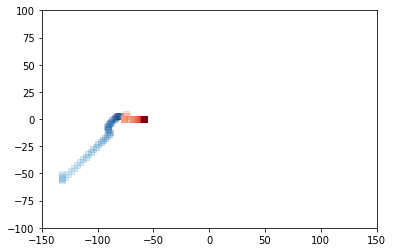

In [11]:
import matplotlib.pyplot as plt

fig= plt.figure()
ax=fig.add_subplot()
ax.set_xlim((-150,150))
ax.set_ylim((-100,100))
ax.scatter(t1.T[0], t1.T[1], c=[i for i in range(61)], cmap="Blues", marker="s", alpha=0.25)
ax.scatter(t2.T[0], t2.T[1], c=[i for i in range(61)], cmap="Reds", marker="s", alpha=0.25)
plt.show()

In [72]:
#function to find the max and min, which is used to define the range to show 

#Limits are at around 250 for x-axis and 200 for y-axis

res=db.frames.aggregate([
    {"$match":{"game":8}},
    {"$group":{"_id":"$game", "position_x_max":{"$max":{"$arrayElemAt":[{"$arrayElemAt":["$players.position",0]},0]}},"position_x_min":{"$min":{"$arrayElemAt":[{"$arrayElemAt":["$players.position",0]},0]}},"position_y_max":{"$max":{"$arrayElemAt":[{"$arrayElemAt":["$players.position",0]},1]}},"position_y_min": {"$min":{"$arrayElemAt":[{"$arrayElemAt":["$players.position",0]},1]}}}}
])

In [73]:
list(res)

[{'_id': 8,
  'position_x_max': 157.4256134033203,
  'position_x_min': -225.3148956298828,
  'position_y_max': 201.47891235351562,
  'position_y_min': -17.251192092895508}]

In [2]:
from slippi_graphs import print_trajectories

print_trajectories(db, ["marth", "fox"], "up_smash", 60)

In [42]:
iterator=db.frames.find({}, {"time_0":{"$arrayElemAt":["$players.will_get_hit_by.time",0]}, "time_1":{"$arrayElemAt":["$players.will_get_hit_by.time", 1]}, "_id":0}, batch_size=100000).limit(200000)
df=pd.DataFrame(data=list(iterator))

In [45]:
df=df.dropna()
times=df.groupby("time_0").count()["time_1"]+df.groupby("time_1").count()["time_0"]

<AxesSubplot:xlabel='time_0'>

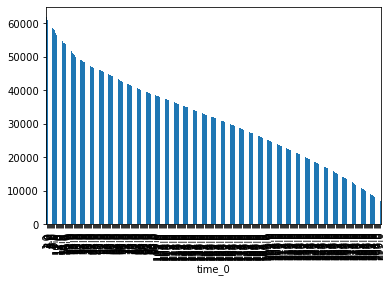

In [63]:
total_times=np.zeros((300,))
for i in range(100):
    iterator=db.frames.find({}, {"time_0":{"$arrayElemAt":["$players.will_get_hit_by.time",0]}, "time_1":{"$arrayElemAt":["$players.will_get_hit_by.time", 1]}, "_id":0}, batch_size=100000).skip(200000*i).limit(200000)
    df=pd.DataFrame(data=list(iterator))
    df=df.dropna()
    times=df.groupby("time_0").count()["time_1"]+df.groupby("time_1").count()["time_0"]
    total_times=times+total_times
total_times.drop(0).plot.bar()

In [65]:
total_times.drop(0)

time_0
1.0      61802.0
2.0      60956.0
3.0      60153.0
4.0      59680.0
5.0      59076.0
          ...   
295.0     7926.0
296.0     7724.0
297.0     7487.0
298.0     7253.0
299.0     7035.0
Length: 299, dtype: float64

<AxesSubplot:>

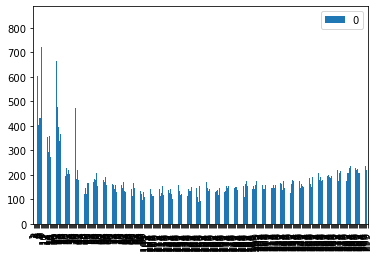

In [80]:
start_times=pd.DataFrame(data=np.zeros(300,))
for i in range(299):
    start_times.iloc[i]=(total_times[i]-total_times[i+1])
start_times.drop(0).plot.bar()

<AxesSubplot:>

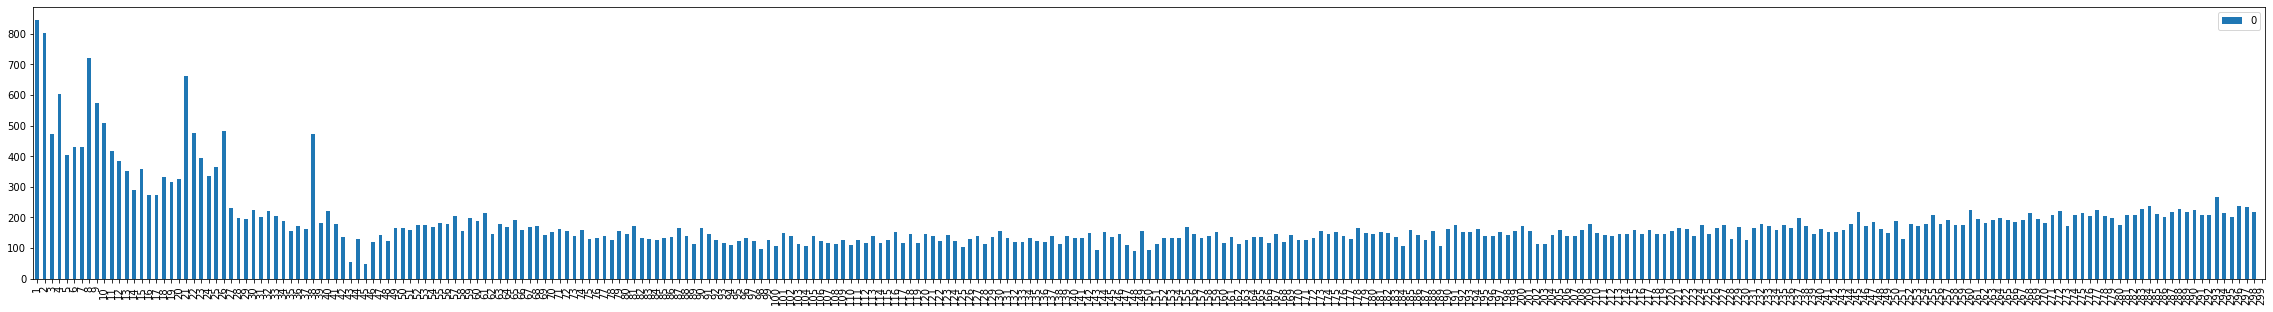

In [98]:
start_times.drop(0).plot.bar(figsize=(40,5))
# 45 frames seems to be a cutoff to where an interaction can be considered to be in neutral or in combo/disadvantage

<AxesSubplot:xlabel='time_0'>

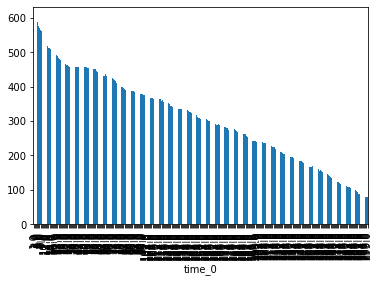

In [48]:
times.drop(0).plot.bar()